# Credit Card Fraud Detection
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [1]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

In [2]:
# Import Data
data = pd.read_csv('creditcard.csv')

# Get samples for each class
fraudsDF = data[data.Class == 1]
normalDF = data[data.Class == 0]
N = len(data)

print("Number of Features: ", fraudsDF.shape[1])
print("Number of Fraudulent Transactions: ",fraudsDF.shape[0], "({:.2f}%)".format(100*fraudsDF.shape[0]/N))
print("Number of Normal Transactions",normalDF.shape[0], "({:.2f}%)".format(100*normalDF.shape[0]/N))

#See the dataset
data.head()

Number of Features:  31
Number of Fraudulent Transactions:  492 (0.17%)
Number of Normal Transactions 284315 (99.83%)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Regularize Features & Data Prep

In [3]:
#Scaling amount 
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = std_scale.fit_transform(data['Time'].values.reshape(-1, 1))
# data = data.drop(['Time'], axis=1)

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [4]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#check distributions of data
fraud_train_pct = y_train[y_train== 1].value_counts()/len(y_train)*100
fraud_test_pct = y_test[y_test == 1].value_counts()/len(y_test)*100

print('Training set frauds:', round(fraud_train_pct[1], 2), '%')
print('Test set frauds:', round(fraud_test_pct[1], 2), '%')


Training set frauds: 0.17 %
Test set frauds: 0.17 %


#### Undersample the Training Set to Balance the Classes

In [5]:

#find instances of fraud in training set
train_fraud_indices = np.array(y_train[y_train== 1].index)
n_train_fraud = len(train_fraud_indices)
train_nonfraud_indices = np.array(y_train[y_train== 0].index)

#Randomly select number of non-fraud transactions to match the number of fraud transactions
random_indices = np.random.choice(train_nonfraud_indices, n_train_fraud, replace = False)
undersample_indices = np.concatenate([train_fraud_indices, random_indices])

#Resample the training data
x_train_u  = x_train.loc[undersample_indices]
y_train_u = y_train.loc[undersample_indices]

#Check the new distribution of data
fraud_train_pct_u = y_train_u[y_train_u== 1].value_counts()/len(y_train_u)*100
nonfraud_train_pct_u = y_train_u[y_train_u== 0].value_counts()/len(y_train_u)*100
print('Training set frauds:', round(fraud_train_pct_u[1], 2), '%')
print('Training set non-frauds:', round(nonfraud_train_pct_u[0], 2), '%')

Training set frauds: 50.0 %
Training set non-frauds: 50.0 %


## SVM

In [6]:
# Functions to test and train different SVM Models
from sklearn.metrics import classification_report
def train_svm_model(x,y,C,kernel,class_weight):
    model = SVC(C=C,kernel=kernel,class_weight=class_weight)
    model.fit(x, y)
    return model
    
def test_svm_model(x,y,model):
    prediction = model.predict(x)
    print(confusion_matrix(y,prediction))
    # ConfusionMatrixDisplay.from_predictions(y,prediction)
    # report= classification_report(y, prediction)
    # print(report)

#### Balanced Linear Model

In [7]:
# Balanced Model
svm_base = train_svm_model(x_train_u,y_train_u,1,'linear','balanced')
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,svm_base)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,svm_base)

Base SVM Confusion Matrix tested on Training Set
[[386   8]
 [ 22 372]]
Base SVM Confusion Matrix tested on Test Set
[[54641  2223]
 [   12    86]]


#### Weighted Linear Model

In [8]:
# Balanced Model
svm_base = train_svm_model(x_train_u,y_train_u,1,'linear','balanced')
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,svm_base)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,svm_base)

Base SVM Confusion Matrix tested on Training Set
[[386   8]
 [ 22 372]]
Base SVM Confusion Matrix tested on Test Set
[[54641  2223]
 [   12    86]]


#### Base RBF Model

In [9]:
model = SVC(C=1,kernel='rbf',gamma='scale')
model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,model)

Base SVM Confusion Matrix tested on Training Set
[[390   4]
 [ 41 353]]
Base SVM Confusion Matrix tested on Test Set
[[56048   816]
 [   13    85]]


#### Base Poly Model

In [10]:
model = SVC(C=10,degree=1,kernel='poly',gamma='scale')
model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,model)

Base SVM Confusion Matrix tested on Training Set
[[390   4]
 [ 34 360]]
Base SVM Confusion Matrix tested on Test Set
[[55918   946]
 [   13    85]]


### Hyperparameter Selection via Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def Grid_Search_SVM(parameters, score, x_train, y_train, x_test, y_test):
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), parameters, scoring="%s_macro" % score,n_jobs=-1)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    # print()
    # print("Grid scores on development set:")
    # print()
    # means = clf.cv_results_["mean_test_score"]
    # stds = clf.cv_results_["std_test_score"]
    # for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    #     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    # print()

    # print("Detailed classification report:")
    # print()
    # print("The model is trained on the full development set.")
    # print("The scores are computed on the full evaluation set.")
    # print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()
    return clf.best_estimator_

In [12]:
# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": ['scale', 0.01,1e-3, 1e-4], "C": [1, 10, 100, 1000], "class_weight": [None,'balanced',{0:1, 1:1},{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000], "class_weight": ['balanced',{0:1, 1:1},{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]},
    {"kernel": ["poly"], "gamma": ['scale', 0.01,1e-3, 1e-4], "degree":[3,4,5], "C": [1, 10, 100, 1000], "class_weight": [None,'balanced',{0:1, 1:1},{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]},
]
scores = ["precision", "recall"]

### RBF Kernel

In [13]:
best_model = Grid_Search_SVM(tuned_parameters[0], scores[0], x_train_u, y_train_u, x_test, y_test)
# best_model = best_model.best_estimator_

# best_model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,best_model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,best_model)

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.89      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962


Base SVM Confusion Matrix tested on Training Set
[[390   4]
 [ 24 370]]
Base SVM Confusion Matrix tested on Test Set
[[55322  1542]
 [   11    87]]


In [14]:
best_model = Grid_Search_SVM(tuned_parameters[0], scores[1], x_train_u, y_train_u, x_test, y_test)
# best_model = best_model.best_estimator_

# best_model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,best_model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,best_model)

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'class_weight': {0: 1, 1: 1.75}, 'gamma': 0.001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962


Base SVM Confusion Matrix tested on Training Set
[[387   7]
 [  7 387]]
Base SVM Confusion Matrix tested on Test Set
[[53701  3163]
 [    7    91]]


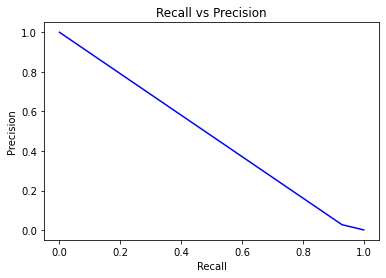

In [15]:
prediction = best_model.predict(x_test)
precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Linear Kernel

In [16]:
best_model = Grid_Search_SVM(tuned_parameters[1], scores[1], x_train_u, y_train_u, x_test, y_test)
# best_model = best_model.best_estimator_

# best_model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,best_model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,best_model)

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.88      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.92      0.53     56962
weighted avg       1.00      0.96      0.98     56962


Base SVM Confusion Matrix tested on Training Set
[[386   8]
 [ 22 372]]
Base SVM Confusion Matrix tested on Test Set
[[54641  2223]
 [   12    86]]


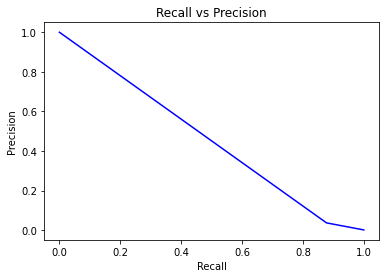

In [17]:
prediction = best_model.predict(x_test)
precision, recall, th = precision_recall_curve(y_test, prediction)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Poly Kernel

In [18]:
best_model = Grid_Search_SVM(tuned_parameters[2], scores[0], x_train_u, y_train_u, x_test, y_test)
# best_model = best_model.best_estimator_

# best_model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,best_model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,best_model)

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 1.75}, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.87      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.92      0.56     56962
weighted avg       1.00      0.98      0.99     56962


Base SVM Confusion Matrix tested on Training Set
[[393   1]
 [ 29 365]]
Base SVM Confusion Matrix tested on Test Set
[[55809  1055]
 [   13    85]]


In [19]:
# Balanced Model 'C': 1000, 'class_weight': None, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'
model = SVC(C=1000,degree=4,kernel='poly',gamma=0.01)
model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,model)

Base SVM Confusion Matrix tested on Training Set
[[394   0]
 [ 13 381]]
Base SVM Confusion Matrix tested on Test Set
[[54918  1946]
 [   11    87]]


In [20]:
print(clf.best_params_)

model = clf.best_estimator_
model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,model)

NameError: name 'clf' is not defined

In [ ]:
print(clf.best_params_)

model = clf.best_estimator_
model.fit(x_train_u,y_train_u)
print("Base SVM Confusion Matrix tested on Training Set")
test_svm_model(x_train_u,y_train_u,model)
print("Base SVM Confusion Matrix tested on Test Set")
test_svm_model(x_test,y_test,model)

{'C': 1000, 'class_weight': {0: 1, 1: 1.75}, 'kernel': 'linear'}
Base SVM Confusion Matrix tested on Training Set
[[379  15]
 [ 17 377]]
Base SVM Confusion Matrix tested on Test Set
[[53628  3236]
 [   10    88]]


In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model.best_params_)

{'C': 1000, 'class_weight': {0: 1, 1: 1.75}, 'kernel': 'linear'}
